In [ ]:
import tensorflow as tf
tf.compat.v1.enable_eager_execution()
print("Eager execution:", tf.executing_eagerly())

Eager execution: True


In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error,mean_squared_error
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,SimpleRNN,LSTM,Dropout
import matplotlib.pyplot as plt

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving dataset.csv to dataset.csv


In [ ]:
df = pd.read_csv('dataset.csv')
df.head()

,Unnamed: 0,open,high,low,close,volume,marketCap,timestamp,crypto_name,date
0,0,112.900002,118.800003,107.142998,115.910004,0.0,1.288693e+09,2013-05-05T23:59:59.999Z,Bitcoin,2013-05-05
1,1,3.493130,3.692460,3.346060,3.590890,0.0,6.229819e+07,2013-05-05T23:59:59.999Z,Litecoin,2013-05-05
2,2,115.980003,124.663002,106.639999,112.300003,0.0,1.249023e+09,2013-05-06T23:59:59.999Z,Bitcoin,2013-05-06
3,3,3.594220,3.781020,3.116020,3.371250,0.0,5.859436e+07,2013-05-06T23:59:59.999Z,Litecoin,2013-05-06
4,4,112.250000,113.444000,97.699997,111.500000,0.0,1.240594e+09,2013-05-07T23:59:59.999Z,Bitcoin,2013-05-07


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72946 entries, 0 to 72945
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Unnamed: 0   72946 non-null  int64  
 1   open         72946 non-null  float64
 2   high         72946 non-null  float64
 3   low          72946 non-null  float64
 4   close        72946 non-null  float64
 5   volume       72946 non-null  float64
 6   marketCap    72946 non-null  float64
 7   timestamp    72946 non-null  object 
 8   crypto_name  72946 non-null  object 
 9   date         72946 non-null  object 
dtypes: float64(6), int64(1), object(3)
memory usage: 5.6+ MB


In [ ]:
# data = pd.read_csv('dataset.csv')
ticker = 'RELIANCE.NS'
start_data = '2023-08-25'
end_data = '2024-08-25'
data = yf.download(ticker,start=start_data,end=end_data)
data = data.reset_index()
data.head()

/tmp/ipython-input-3743229334.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker,start=start_data,end=end_data)
[*********************100%***********************]  1 of 1 completed


Price,Date,Close,High,Low,Open,Volume
Ticker,,RELIANCE.NS,RELIANCE.NS,RELIANCE.NS,RELIANCE.NS,RELIANCE.NS
0,2023-08-25,1225.107544,1243.297861,1212.327137,1218.977863,22222400
1,2023-08-28,1212.897705,1232.874844,1206.619224,1226.918927,12580826
2,2023-08-29,1201.283813,1217.712147,1195.228534,1217.017338,16876644
3,2023-08-30,1200.142334,1212.525656,1198.628514,1207.066065,12168946
4,2023-08-31,1194.657837,1203.591714,1191.133870,1202.599061,21638600


In [ ]:
print(df.shape)
print(data.shape)

(72946, 10)
(243, 6)


In [ ]:
def plot_series(data,title='Time Series Data',xlabel='Data',ylabel='Value',figsize=(16,4)):
  plt.figure(figsize=figsize)
  plt.plot(data)
  plt.title(title)
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.show()

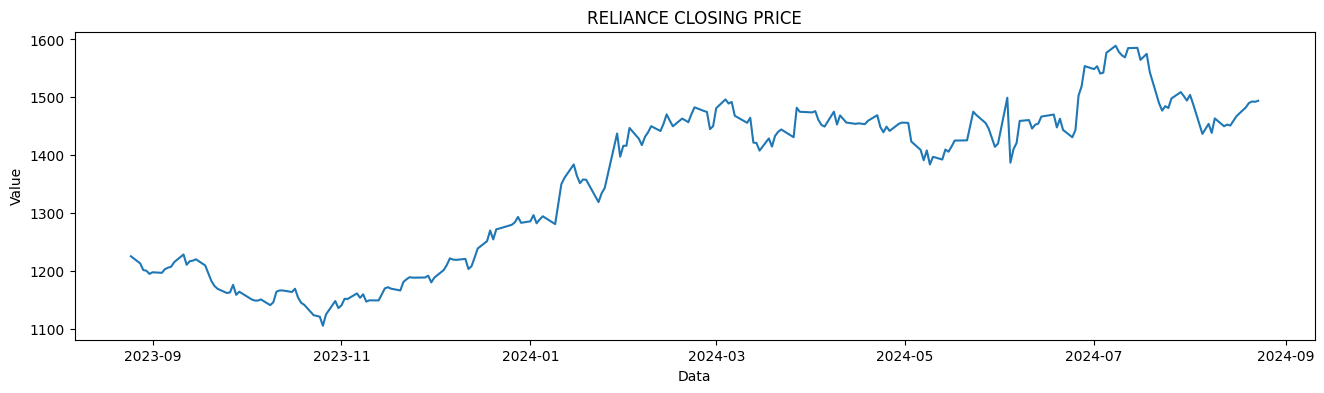

In [ ]:
rel_close = data[['Date','Close']]
rel_close.set_index('Date', inplace=True)
# rel_close_500 = rel_close.iloc[:500]
plot_series(rel_close, title='RELIANCE CLOSING PRICE')

In [ ]:
train_size = int(len(rel_close)*0.85)
train = rel_close[:train_size]
test = rel_close[train_size:]

In [ ]:
scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(train)
scaled_test = scaler.transform(test)

In [ ]:
def build_rnn_model(input_shape):
  model = Sequential()
  model.add(SimpleRNN(50,input_shape=input_shape))
  model.add(Dropout(rate=0.5))
  model.add(Dense(1))
  model.compile(optimizer='adam',loss='mse')
  return model

In [ ]:
def build_lstm_model(input_shape):
  model = Sequential()
  model.add(LSTM(50,input_shape=input_shape))
  model.add(Dropout(rate=0.5))
  model.add(Dense(1))
  model.compile(optimizer='adam',loss='mse')
  return model

In [ ]:
length = 16
batch_size = 1
n_features = 1

train_generator = TimeseriesGenerator(scaled_train,scaled_train,
                                      length =length,batch_size = batch_size)

In [ ]:
rnn_model = build_rnn_model(input_shape=(length,n_features))
rnn_model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 50)             │         2,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,651 (10.36 KB)

 Trainable params: 2,651 (10.36 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
rnn_model.fit(train_generator, epochs=100, verbose=1)

Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


190/190 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.2516
Epoch 2/100
190/190 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0588
Epoch 3/100
190/190 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0415
Epoch 4/100
190/190 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0253
Epoch 5/100
190/190 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0251
Epoch 6/100
190/190 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0203
Epoch 7/100
190/190 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0161
Epoch 8/100
190/190 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0158
Epoch 9/100
190/190 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0167
Epoch 10/100
190/190 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0101
Epoch 11/100
190/190 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0124
Epoch 12/100
190/190 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0136
Epoch 13/100
190/190 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0142
Epoch 14/100
190/190 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0097
Epoch 15/100
190/190 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step -

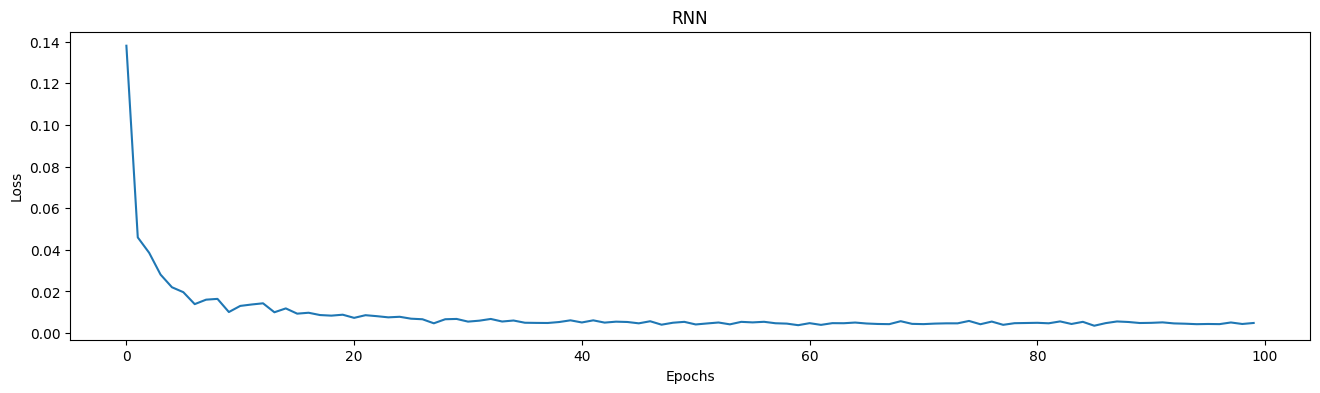

In [ ]:
losses_run = pd.DataFrame(rnn_model.history.history)
plot_series(losses_run,title='RNN',xlabel='Epochs',ylabel='Loss')

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


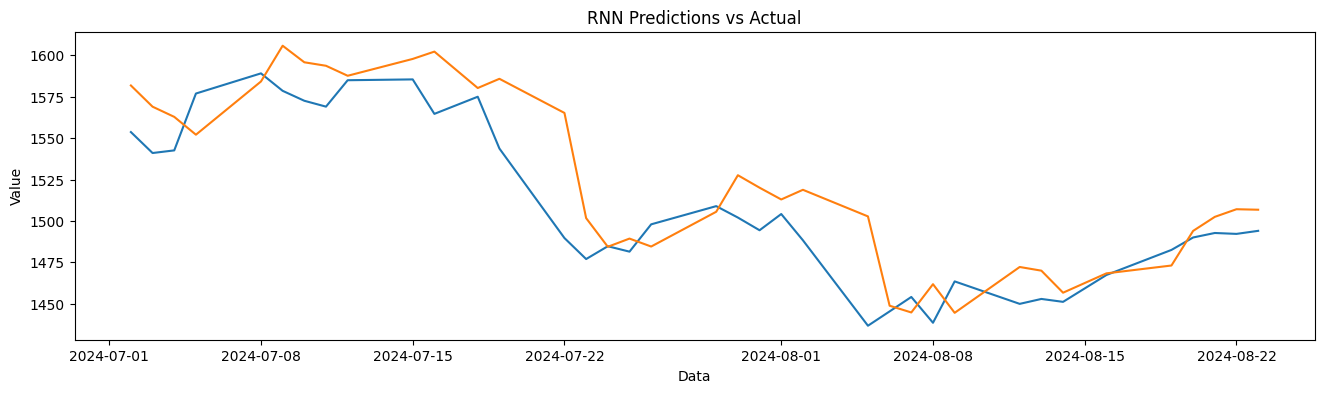

RNN RMSE :25.236648504394854
RNN MAE :19.326885223388672


In [ ]:
data_for_pred = np.concatenate((scaled_train[-length:], scaled_test), axis=0)

test_generator = TimeseriesGenerator(data_for_pred, data_for_pred,
                                     length=length, batch_size=1)

predictions_scaled = rnn_model.predict(test_generator)
predictions = scaler.inverse_transform(predictions_scaled)

test = test.copy()
test['RNN_Predictions'] = predictions.flatten()

plot_series(test[['Close', 'RNN_Predictions']], title='RNN Predictions vs Actual')

rmse_rnn = np.sqrt(mean_squared_error(test['Close'], test['RNN_Predictions']))
mae_rnn = mean_absolute_error(test['Close'], test['RNN_Predictions'])

print(f'RNN RMSE :{rmse_rnn}')
print(f'RNN MAE :{mae_rnn}')

In [ ]:
#LSTM

lstm_model = build_lstm_model(input_shape=(length,n_features))
lstm_model.summary()

lstm_model.fit(train_generator, epochs=100,shuffle =False)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50)             │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,451 (40.82 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
190/190 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0120
Epoch 2/100
190/190 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0215
Epoch 3/100
190/190 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0168
Epoch 4/100
190/190 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0179
Epoch 5/100
190/190 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0143
Epoch 6/100
190/190 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0098
Epoch 7/100
190/190 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0108
Epoch 8/100
190/190 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0093
Epoch 9/100
190/190 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0105
Epoch 10/100
190/190 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0086
Epoch 11/100
190/190 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0074
Epoch 12/100
190/190 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0070
Epoch 13/100
190/190 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0076
Epoch 14/100
190/190 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0065
Epoch 15/100
190/190 ━━━━━━━━━━━━━━━━━━━━ 1

 1/37 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


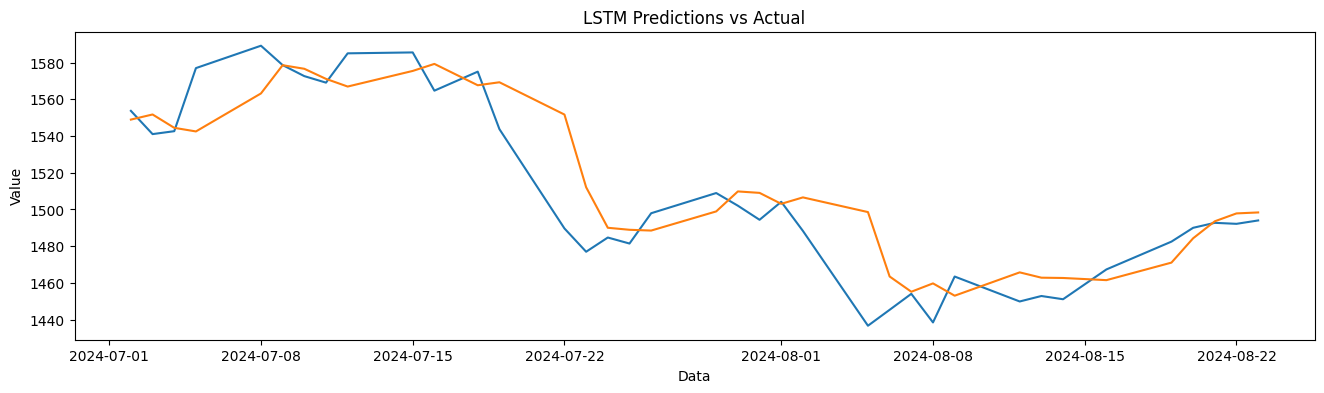

LSTM RMSE :19.99061822191928
LSTM MAE :13.911627769470215


In [ ]:
data_for_pred = np.concatenate((scaled_train[-length:], scaled_test), axis=0)

test_generator = TimeseriesGenerator(data_for_pred, data_for_pred,
                                     length=length, batch_size=1)

predictions_scaled = lstm_model.predict(test_generator)
predictions = scaler.inverse_transform(predictions_scaled)

test = test.copy()
test['LSTM_Predictions'] = predictions.flatten()

plot_series(test[['Close', 'LSTM_Predictions']], title='LSTM Predictions vs Actual')

rmse_lstm = np.sqrt(mean_squared_error(test['Close'], test['LSTM_Predictions']))
mae_lstm = mean_absolute_error(test['Close'], test['LSTM_Predictions'])

print(f'LSTM RMSE :{rmse_lstm}')
print(f'LSTM MAE :{mae_lstm}')

In [ ]:
full_scaler = MinMaxScaler()
scaled_full_date = full_scaler.fit_transform(rel_close)

full_generator = TimeseriesGenerator(scaled_full_date,scaled_full_date,length=length,
                                     batch_size=batch_size)

rnn_full_model = build_rnn_model(input_shape=(length,n_features))
rnn_full_model.summary()

rnn_full_model.fit(full_generator,epochs=100,shuffle=False)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_1 (SimpleRNN)        │ (None, 50)             │         2,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,651 (10.36 KB)

 Trainable params: 2,651 (10.36 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


227/227 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0458
Epoch 2/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0218
Epoch 3/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0105
Epoch 4/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0103
Epoch 5/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0125
Epoch 6/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0085
Epoch 7/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0087
Epoch 8/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0060
Epoch 9/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0070
Epoch 10/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0059
Epoch 11/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0070
Epoch 12/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0063
Epoch 13/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0056
Epoch 14/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0068
Epoch 15/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step -

In [ ]:
rnn_forecast = []
current_batch_rnn = scaled_full_date[-length:].reshape((1,length,n_features))

for i in range(15):
  current_pred =rnn_full_model.predict(current_batch_rnn)[0]
  rnn_forecast.append(current_pred)
  current_batch_rnn = np.append(current_batch_rnn[:, 1:, :],[[current_pred]],axis=1)

rnn_forecast = full_scaler.inverse_transform(rnn_forecast)

rnn_forecas_dates = pd.date_range(start=rel_close.index[-1]+pd.Timedelta(days=1),periods = 15)
rnn_forecast_df = pd.DataFrame(rnn_forecast,index=rnn_forecas_dates,columns=['RNN_Forecast'])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


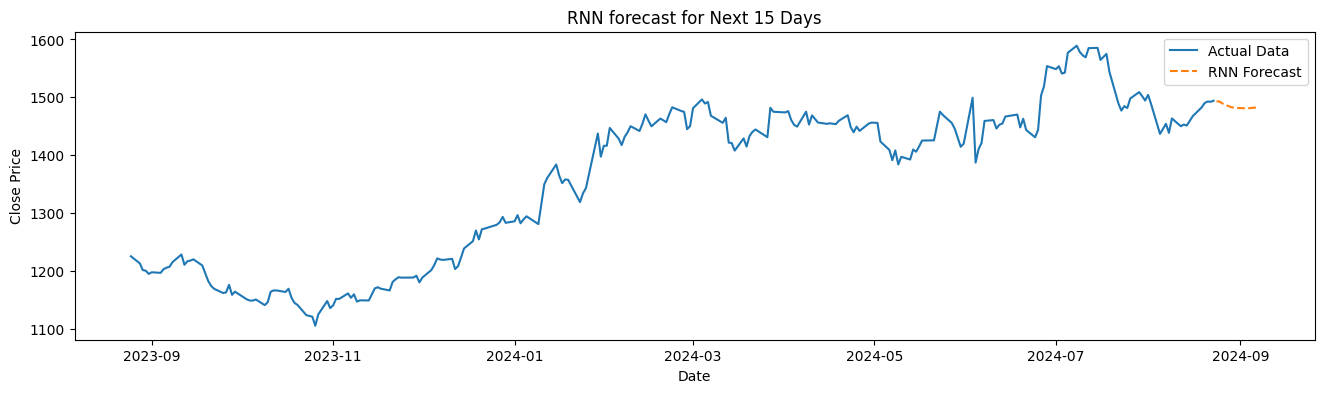

In [ ]:
plt.figure(figsize=(16,4))
plt.plot(rel_close,label='Actual Data')
plt.plot(rnn_forecast_df,label='RNN Forecast',linestyle = '--')
plt.title('RNN forecast for Next 15 Days')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

In [ ]:
# LSTM
lstm_full_model = build_rnn_model(input_shape=(length,n_features))
lstm_full_model.summary()

lstm_full_model.fit(full_generator,epochs=100,shuffle=False)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_2 (SimpleRNN)        │ (None, 50)             │         2,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,651 (10.36 KB)

 Trainable params: 2,651 (10.36 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0370
Epoch 2/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0174
Epoch 3/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0127
Epoch 4/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0126
Epoch 5/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0075
Epoch 6/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0075
Epoch 7/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0060
Epoch 8/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069
Epoch 9/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069
Epoch 10/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0056
Epoch 11/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0078
Epoch 12/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0051
Epoch 13/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0054
Epoch 14/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0055
Epoch 15/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 1

In [ ]:
lstm_forecast = []
current_batch_lstm = scaled_full_date[-length:].reshape((1,length,n_features))

for i in range(15):
  current_pred =lstm_full_model.predict(current_batch_lstm)[0]
  lstm_forecast.append(current_pred)
  current_batch_lstm = np.append(current_batch_lstm[:, 1:, :],[[current_pred]],axis=1)

lstm_forecast = full_scaler.inverse_transform(lstm_forecast)

lstm_forecas_dates = pd.date_range(start=rel_close.index[-1]+pd.Timedelta(days=1),periods = 15)
lstm_forecast_df = pd.DataFrame(lstm_forecast,index=lstm_forecas_dates,columns=['LSTM_Forecast'])

In [ ]:
plt.figure(figsize=(16,4))
plt.plot(rel_close,label='Actual Data')
plt.plot(rnn_forecast_df,label='RNN Forecast',linestyle = '--')
plt.title('RNN forecast for Next 15 Days')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(data['Open'], label='Open')
plt.plot(data['High'], label='High')
plt.plot(data['Low'], label='Low')
plt.plot(data['Close'], label='Close')

plt.title('Stock Price Comparison (Open, High, Low, Close)')
plt.xlabel('Index / Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

In [1]:
# import plotly.graph_objects as go
# df = df.sort_values('date')

# df['MA20'] = df['close'].rolling(window=20).mean()
# df['MA50'] = df['close'].rolling(window=50).mean()

# fig = go.Figure()


# fig.add_trace(go.Candlestick(
#     x=df['date'],
#     open=df['open'],
#     high=df['high'],
#     low=df['low'],
#     close=df['close'],
#     name='Candlestick'
# ))

# # میانگین متحرک 20 روزه
# fig.add_trace(go.Scatter(
#     x=df['date'], y=df['MA20'],
#     line=dict(color='blue', width=1.5),
#     name='MA 20'
# ))

# # میانگین متحرک 50 روزه
# fig.add_trace(go.Scatter(
#     x=df['date'], y=df['MA50'],
#     line=dict(color='orange', width=1.5),
#     name='MA 50'
# ))

# # حجم معاملات
# fig.add_trace(go.Bar(
#     x=df['date'], y=df['volume'],
#     name='Volume', marker_color='lightgray',
#     yaxis='y2', opacity=0.4
# ))

# # تنظیم محور دوم برای حجم معاملات
# fig.update_layout(
#     yaxis=dict(title='Price'),
#     yaxis2=dict(title='Volume', overlaying='y', side='right', showgrid=False),
#     xaxis_rangeslider_visible=False,
#     title='Stock/Crypto Candlestick Chart with MA & Volume',
#     template='plotly_dark',
#     legend=dict(x=0, y=1)
# )
# fig.show()
